# Imports:

In [1]:
from microscope import *
import ipywidgets as widgets

%matplotlib inline

C:\tools\Manim\Lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Interactive simulation:

In [2]:
l_1 = 1064e-9
l_2 = 532e-9
pixel_size = 1e-10
N_POINTS = 256  # Resolution of image

input_coordinate_system = CoordinateSystem(dxdydz=(pixel_size, pixel_size), n_points=(N_POINTS, N_POINTS))
first_wave = WaveFunction(psi=np.ones((N_POINTS, N_POINTS)),
                          coordinates=input_coordinate_system,
                          E0=Joules_of_keV(300))

dummy_sample = SamplePropagator(dummy_potential=f'letters_{N_POINTS}',
                                coordinates_for_dummy_potential=CoordinateSystem(axes=(input_coordinate_system.x_axis,
                                                                                       input_coordinate_system.y_axis,
                                                                                       np.linspace(-5e-10, 5e-10, 2)
                                                                                       )))


first_lens = LensPropagator(focal_length=3.3e-3, fft_shift=True)
second_lens = LensPropagator(focal_length=3.3e-3, fft_shift=False)

In [3]:
E_1_default = find_amplitude_for_phase(starting_E=1e7, cavity_type='analytical', print_progress=False, NA_1=0.05)
def f(NA_1, defocus_nm, Cs_mm, n_electrons, ring_cavity, E_1):
    cavity = CavityAnalyticalPropagator(l_1=l_1, l_2=l_2, E_1=E_1, NA_1=NA_1, ring_cavity=ring_cavity)
    aberration_propagator = AberrationsPropagator(Cs=Cs_mm*1e-3, defocus=defocus_nm*1e-9, astigmatism_parameter=0, astigmatism_orientation=0)

    M_2f_a = Microscope([dummy_sample, first_lens, cavity, second_lens, aberration_propagator], n_electrons_per_square_angstrom=n_electrons)
    pic_2f_a = M_2f_a.take_a_picture(first_wave)

#     fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    fig = plt.figure(figsize=(14, 10))
    phase_mask = cavity.load_or_calculate_phase_and_amplitude_mask(M_2f_a.step_of_propagator(cavity).output_wave)
    middle_phase_mask_value = phase_mask[phase_mask.shape[0] // 2, phase_mask.shape[1] // 2]
    attenuation_factor = np.abs(middle_phase_mask_value)
    phase_factor = np.real(np.angle(middle_phase_mask_value))
    plt.title(f' phase_factor over pi{phase_factor / np.pi:.2f} {attenuation_factor=:.2f}')
    plt.imshow(pic_2f_a.values, extent=pic_2f_a.coordinates.limits)
    plt.colorbar()

    plt.xlabel("y")
    plt.ylabel("x")
    return phase_factor, attenuation_factor

I = widgets.interactive(f, NA_1=(0.001, 0.2, 0.01), defocus_nm=(-1000, 1000, 1), Cs_mm=(0, 5, 0.01), n_electrons=(0, 3000, 20), ring_cavity=True, E_1=(0, E_1_default * 2, E_1_default / 100));
button = widgets.Button(description="Save Image")

display(button)
display(I)


def on_button_clicked(b):
    d = dict(zip([s.description for s in I.children[:-1]], [s.value for s in I.children[:-1]]))
    phase_factor, attenuation_factor = f(**d)
    text_to_add = f' phase_factor over pi{phase_factor / np.pi:.2f} {attenuation_factor=:.2f}'
    title = "".join([f'{key}= {value:.2e} ' if isinstance(value, float) else f'{key}= {value} '  for key, value in d.items()])
    title += text_to_add
    plt.title(title)
    plt.savefig(f"examples\\{title}.png")
    plt.close()
button.on_click(on_button_clicked)

Button(description='Save Image', style=ButtonStyle())

interactive(children=(FloatSlider(value=0.091, description='NA_1', max=0.2, min=0.001, step=0.01), IntSlider(v…

In [42]:
def f(infinitesimal_mask, radius_microns, mask_phase_in_pies, mask_attenuation, defocus_nm, Cs_nm, n_electrons):
    if infinitesimal_mask:
        r = -1
    else:
        r = radius_microns * 1e-6
            
    cavity = DummyPhaseMask(mask_width_meters=r, mask_phase=-mask_phase_in_pies * np.pi, mask_attenuation=mask_attenuation)
    aberration_propagator = AberrationsPropagator(Cs=Cs_nm*1e-9, defocus=defocus_nm*1e-9, astigmatism_parameter=0, astigmatism_orientation=0)
    
    M_2f_a = Microscope([dummy_sample, first_lens, cavity, second_lens, aberration_propagator], n_electrons_per_square_angstrom=n_electrons)
    pic_2f_a = M_2f_a.take_a_picture(first_wave)
    
    fig = plt.figure(figsize=(14, 10))
    attenuation_factor = mask_attenuation
    phase_factor = mask_phase_in_pies
    plt.title(f' phase_factor over pi{phase_factor:.2f} {attenuation_factor=:.2f}')
    plt.imshow(pic_2f_a.values)  # , extent=pic_2f_a.coordinates.limits
    plt.colorbar()
    
    plt.xlabel("y")
    plt.ylabel("x")
#     M_2f_a.plot_step(cavity)
    return phase_factor, attenuation_factor

I = widgets.interactive(f, infinitesimal_mask=True, radius_microns=(0, 100, 1), mask_phase_in_pies=(0, 2, 0.1), mask_attenuation=(0,1, 0.01), defocus_nm=(-100, 100, 1), Cs_nm=(0, 100, 1), n_electrons=(0, 300, 2), ring_cavity=True);
button = widgets.Button(description="Save Image")

display(button)
display(I)


def on_button_clicked(b):
    d = dict(zip([s.description for s in I.children[:-1]], [s.value for s in I.children[:-1]]))
    phase_factor, attenuation_factor = f(**d)
    if d['infinitesimal_mask']:
        mask_width='eps'
    else:
        mask_width=f"{d['radius_microns']:.2f}"
    title = f'phase_factor in pies={phase_factor:.2f} attenuation_factor={attenuation_factor:.2f} mask_width_microns={mask_width}defocus_nm={d["defocus_nm"]} Cs_nm={d["Cs_nm"]} n_electrons={d["n_electrons"]}'
    plt.title(title)
    plt.savefig(f"examples\\{title}.png")
    plt.close()
button.on_click(on_button_clicked)

Button(description='Save Image', style=ButtonStyle())

interactive(children=(Checkbox(value=True, description='infinitesimal_mask'), IntSlider(value=50, description=…

# Generate and many plots at once:

In [4]:
N_POINTS = 256  # Resolution of image
pixel_size = 1e-10
# %%
input_coordinate_system = CoordinateSystem(dxdydz=(pixel_size, pixel_size), n_points=(N_POINTS, N_POINTS))
first_wave = WaveFunction(psi=np.ones((N_POINTS, N_POINTS)),
                          coordinates=input_coordinate_system,
                          E0=Joules_of_keV(300))

dummy_sample = SamplePropagator(dummy_potential=f'letters_{N_POINTS}',
                                coordinates_for_dummy_potential=CoordinateSystem(axes=(input_coordinate_system.x_axis,
                                                                                       input_coordinate_system.y_axis,
                                                                                       np.linspace(-5e-10, 5e-10, 2)
                                                                                       )))


first_lens = LensPropagator(focal_length=3.3e-3, fft_shift=True)
second_lens = LensPropagator(focal_length=3.3e-3, fft_shift=False)
for ring_cavity in [True, False]:
    for cavity_propagator in [CavityNumericalPropagator]:   # CavityAnalyticalPropagator
        for NA_1 in [0.05, 0.08, 0.1, 0.15, 0.2]:  #
            for E_2 in [-1, None]:  # (with and without a second laser)
                for Cs in [0, 1e-8, 5e-8]:
                    for defocus in [-1e-7, -5e-8, -1e-8, 1e-8, 5e-8, 1e-8]:
                        if cavity_propagator.__name__ == 'CavityAnalyticalPropagator':
                            cavity_name = 'Analytical'
                        else:
                            cavity_name = 'Numerical'
                        if E_2 == -1:
                            two_lasers = 'True'
                        else:
                            two_lasers = 'False'
                        title = f'NA_1={NA_1}, ring_cavity={ring_cavity}, type={cavity_name},' \
                                f'two_lasers={two_lasers}, Cs={Cs}, defocus={defocus}'
                        print(f"Calculating {title}...", end='\r')
                        C = cavity_propagator(NA_1=NA_1, ring_cavity=ring_cavity, E_2=E_2, ignore_past_files=True)
                        aberrations_propagator = AberrationsPropagator(Cs=Cs, defocus=defocus)
                        M = Microscope([dummy_sample, first_lens, C, second_lens, aberrations_propagator])
                        pic = M.take_a_picture(first_wave)
                        plt.imshow(pic.values, extent=input_coordinate_system.limits)
                        plt.title(title)
#                         plt.savefig(f'Figures\\{title}.png')
                        print(f"Calculating {title} - finished")
print("finished")

Calculating layers 1-3 out of 3 in axis 2type=Numerical,two_lasers=True, Cs=0, defocus=-1e-07...
Calculating layers 1-3 out of 3 in axis 2
for E_1 = 9.2e+08 the resulted phase is -0.50 pi
Calculating layer 1 out of 3 in axis 2
Calculating layers 1-39 out of 256 in axis 1
Calculating layers 40-78 out of 256 in axis 1


KeyboardInterrupt: 

# Compare effective cavity phase masks:

for E_1 = 9.0e+08 the resulted phase is -0.50 pi
for E_1 = 1.3e+09 the resulted phase is -0.50 pi
Calculating layers 1-3 out of 3 in axis 2
Calculating layers 1-3 out of 3 in axis 2
for E_1 = 4.5e+08 the resulted phase is -0.50 pi
Calculating layers 1-3 out of 3 in axis 2
Calculating layers 1-3 out of 3 in axis 2
for E_1 = 9.0e+08 the resulted phase is -0.50 pi
Calculating layers 1-2 out of 3 in axis 2
Calculating layers 3-3 out of 3 in axis 2
Calculating layers 1-2 out of 3 in axis 2
Calculating layers 3-3 out of 3 in axis 2


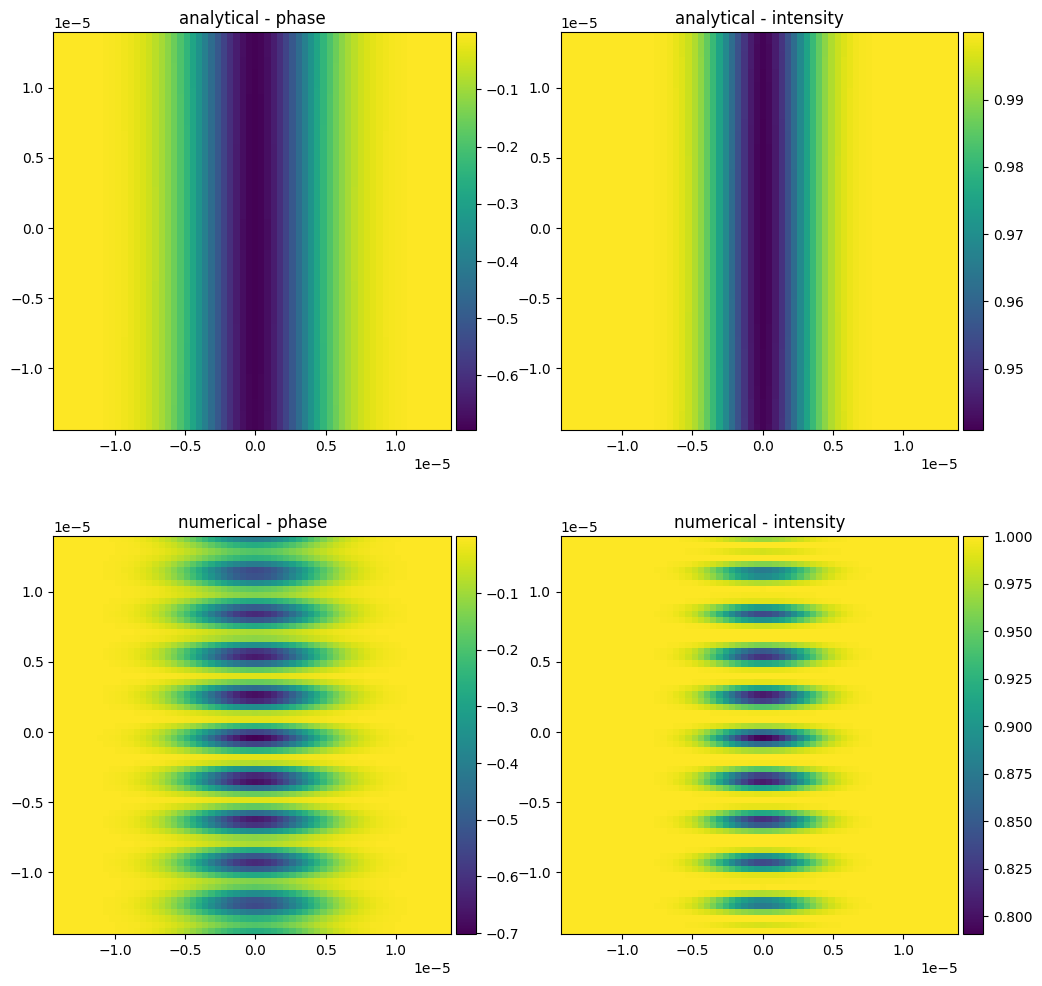

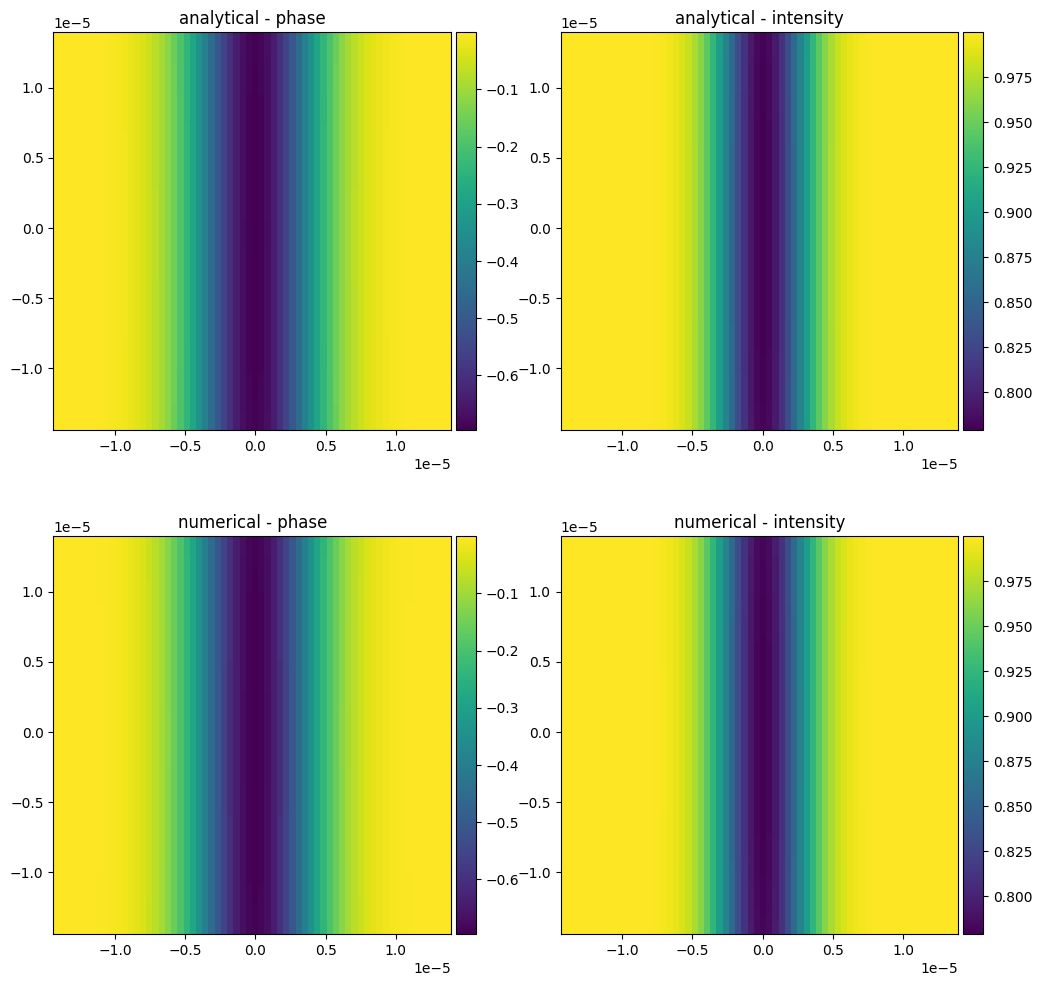

In [5]:
N_POINTS = 64  # Resolution of image
l_1 = 1064e-9
l_2 = 532-9
input_coordinate_system = CoordinateSystem(dxdydz=(pixel_size, pixel_size), n_points=(N_POINTS, N_POINTS))
first_wave = WaveFunction(psi=np.ones((N_POINTS, N_POINTS)),
                          coordinates=input_coordinate_system,
                          E0=Joules_of_keV(1000))

first_lens = LensPropagator(focal_length=3.3e-3, fft_shift=True)


cavity_2f_analytical = CavityAnalyticalPropagator(l_1=l_1, l_2=l_2, E_1=-1, NA_1=NA_1, ring_cavity=False, starting_E_in_auto_E_search=1e3)
cavity_2f_analytical_ring = CavityAnalyticalPropagator(l_1=l_1, l_2=l_2, E_1=-1, NA_1=NA_1, ring_cavity=True)
cavity_2f_numerical = CavityNumericalPropagator(l_1=l_1, l_2=l_2, E_1=-1, NA_1=NA_1, ring_cavity=False, ignore_past_files=False)
cavity_2f_numerical_ring = CavityNumericalPropagator(l_1=l_1, l_2=l_2, E_1=-1, NA_1=NA_1, ring_cavity=True, ignore_past_files=False)

fourier_plane_wave = first_lens.propagate(first_wave)

phase_and_amplitude_mask_a = cavity_2f_analytical.phase_and_amplitude_mask(fourier_plane_wave)
phase_and_amplitude_mask_a_ring = cavity_2f_analytical_ring.phase_and_amplitude_mask(fourier_plane_wave)
phase_and_amplitude_mask_n = cavity_2f_numerical.phase_and_amplitude_mask(fourier_plane_wave)
phase_and_amplitude_mask_n_ring = cavity_2f_numerical_ring.phase_and_amplitude_mask(fourier_plane_wave)


fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(221)
im1 = ax1.imshow(np.real(np.angle(phase_and_amplitude_mask_a)), extent=fourier_plane_wave.coordinates.limits)
divider = make_axes_locatable(ax1)
ax1.set_title('analytical - phase')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(np.abs(phase_and_amplitude_mask_a)**2, extent=fourier_plane_wave.coordinates.limits)
divider = make_axes_locatable(ax2)
ax2.set_title('analytical - intensity')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(np.real(np.angle(phase_and_amplitude_mask_n)), extent=fourier_plane_wave.coordinates.limits)
divider = make_axes_locatable(ax3)
ax3.set_title('numerical - phase')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(np.abs(phase_and_amplitude_mask_n)**2, extent=fourier_plane_wave.coordinates.limits)
divider = make_axes_locatable(ax4)
ax4.set_title('numerical - intensity')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical')
plt.show()


fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(221)
im1 = ax1.imshow(np.real(np.angle(phase_and_amplitude_mask_a_ring)), extent=fourier_plane_wave.coordinates.limits)
divider = make_axes_locatable(ax1)
ax1.set_title('analytical - phase')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(np.abs(phase_and_amplitude_mask_a_ring)**2, extent=fourier_plane_wave.coordinates.limits)
divider = make_axes_locatable(ax2)
ax2.set_title('analytical - intensity')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(np.real(np.angle(phase_and_amplitude_mask_n_ring)), extent=fourier_plane_wave.coordinates.limits)
divider = make_axes_locatable(ax3)
ax3.set_title('numerical - phase')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(np.abs(phase_and_amplitude_mask_n_ring)**2, extent=fourier_plane_wave.coordinates.limits)
divider = make_axes_locatable(ax4)
ax4.set_title('numerical - intensity')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical')
plt.show()

In [20]:
from IPython.display import display
button = widgets.Button(description="Click Me!")

display(button)

def on_button_clicked(b):
    print("Button clicked.")

button.on_click(on_button_clicked)

Button(description='Click Me!', style=ButtonStyle())

Button clicked.
Button clicked.
Button clicked.
